<a href="https://colab.research.google.com/github/akash-verma22/MPI_Assignments/blob/main/Assignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Question 1

In [3]:
%%writefile sum_cuda.cu
#include <stdio.h>

#define N 1024  // Number of integers to sum

// CUDA kernel for iterative sum approach
__global__ void sumIterative(int *output) {
    if (threadIdx.x == 0) {
        int sum = 0;
        for (int i = 1; i <= N; i++) {
            sum += i;
        }
        output[0] = sum;
    }
}

// CUDA kernel for direct formula approach
__global__ void sumDirect(int *output) {
    if (threadIdx.x == 1) {
        int sum = (N * (N + 1)) / 2;
        output[1] = sum;
    }
}

int main() {
    // Output array on host
    int h_output[2] = {0};
    int *d_output;

    // Allocate memory on device
    cudaMalloc(&d_output, 2 * sizeof(int));

    // Initialize output array on device to zeros
    cudaMemset(d_output, 0, 2 * sizeof(int));

    // Launch kernels with minimal configuration
    printf("Launching kernels...\n");
    sumIterative<<<1, 4>>>(d_output);
    cudaDeviceSynchronize();

    sumDirect<<<1, 4>>>(d_output);
    cudaDeviceSynchronize();

    // Copy results back to host
    cudaMemcpy(h_output, d_output, 2 * sizeof(int), cudaMemcpyDeviceToHost);

    // Print results
    printf("Sum of first %d integers (iterative approach): %d\n", N, h_output[0]);
    printf("Sum of first %d integers (direct formula): %d\n", N, h_output[1]);

    // Verify results
    int expected = (N * (N + 1)) / 2;
    printf("Expected result: %d\n", expected);

    // Free device memory
    cudaFree(d_output);

    return 0;
}

Overwriting sum_cuda.cu


In [4]:
!nvcc sum_cuda.cu -o sum_cuda
!./sum_cuda

Launching kernels...
Sum of first 1024 integers (iterative approach): 0
Sum of first 1024 integers (direct formula): 0
Expected result: 524800


# Question **2**

In [5]:
%%writefile mergesort_compare.cu
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <omp.h>
#include <cuda.h>

#define N 1000

void merge(int* arr, int l, int m, int r) {
    int i, j, k;
    int n1 = m - l + 1;
    int n2 = r - m;

    int *L = (int*)malloc(n1 * sizeof(int));
    int *R = (int*)malloc(n2 * sizeof(int));

    for (i = 0; i < n1; i++) L[i] = arr[l + i];
    for (j = 0; j < n2; j++) R[j] = arr[m + 1 + j];

    i = 0; j = 0; k = l;
    while (i < n1 && j < n2) arr[k++] = (L[i] <= R[j]) ? L[i++] : R[j++];
    while (i < n1) arr[k++] = L[i++];
    while (j < n2) arr[k++] = R[j++];

    free(L);
    free(R);
}

void mergeSortPipeline(int* arr, int l, int r) {
    if (l < r) {
        int m = (l + r) / 2;
        #pragma omp parallel sections
        {
            #pragma omp section
            mergeSortPipeline(arr, l, m);
            #pragma omp section
            mergeSortPipeline(arr, m + 1, r);
        }
        merge(arr, l, m, r);
    }
}

__device__ void mergeCuda(int* arr, int* temp, int l, int m, int r) {
    int i = l, j = m + 1, k = l;
    while (i <= m && j <= r) temp[k++] = (arr[i] <= arr[j]) ? arr[i++] : arr[j++];
    while (i <= m) temp[k++] = arr[i++];
    while (j <= r) temp[k++] = arr[j++];
    for (int x = l; x <= r; x++) arr[x] = temp[x];
}

__global__ void mergeSortCuda(int* arr, int* temp, int width, int n) {
    int tid = blockIdx.x * blockDim.x + threadIdx.x;
    int l = tid * (2 * width);
    int m = l + width - 1;
    int r = l + 2 * width - 1;
    if (r >= n) r = n - 1;
    if (m < r)
        mergeCuda(arr, temp, l, m, r);
}

void parallelMergeSortCuda(int* arr, int n) {
    int *d_arr, *d_temp;
    cudaMalloc(&d_arr, n * sizeof(int));
    cudaMalloc(&d_temp, n * sizeof(int));
    cudaMemcpy(d_arr, arr, n * sizeof(int), cudaMemcpyHostToDevice);

    for (int width = 1; width < n; width *= 2) {
        int numThreads = (n + (2 * width) - 1) / (2 * width);
        mergeSortCuda<<<(numThreads + 255) / 256, 256>>>(d_arr, d_temp, width, n);
        cudaDeviceSynchronize();
    }

    cudaMemcpy(arr, d_arr, n * sizeof(int), cudaMemcpyDeviceToHost);
    cudaFree(d_arr);
    cudaFree(d_temp);
}

void printArray(int* arr, int n) {
    for (int i = 0; i < n; i++) {
        printf("%d ", arr[i]);
        if ((i + 1) % 20 == 0) printf("\n");
    }
    printf("\n");
}

int main() {
    int* arr = (int*)malloc(N * sizeof(int));
    int* arr_copy = (int*)malloc(N * sizeof(int));
    srand(time(NULL));
    for (int i = 0; i < N; i++) {
        arr[i] = rand() % 10000;
        arr_copy[i] = arr[i];
    }

    printf("Unsorted Array:\n");
    printArray(arr, N);

    double start = omp_get_wtime();
    mergeSortPipeline(arr, 0, N - 1);
    double end = omp_get_wtime();
    printf("\nSorted Array using Pipelined Merge Sort:\n");
    printArray(arr, N);
    printf("\nPipelined Merge Sort Time: %.6f seconds\n", end - start);

    start = omp_get_wtime();
    parallelMergeSortCuda(arr_copy, N);
    end = omp_get_wtime();
    printf("\nSorted Array using CUDA Merge Sort:\n");
    printArray(arr_copy, N);
    printf("\nCUDA Merge Sort Time: %.6f seconds\n", end - start);

    free(arr);
    free(arr_copy);
    return 0;
}

Writing mergesort_compare.cu


In [6]:
!nvcc mergesort_compare.cu -o mergesort_compare -Xcompiler -fopenmp
!./mergesort_compare

Unsorted Array:
8374 6927 2137 7156 8828 9462 5817 7160 6244 7 7619 8845 1921 6858 6397 3921 5774 6257 531 1569 
277 1916 9845 7252 454 1016 3174 5964 3856 378 8900 8582 7305 7389 2090 6133 3203 7908 9645 9447 
4267 3617 4644 6188 475 7393 6461 2601 3650 6992 4170 280 5260 4015 3884 2066 1383 7058 8030 1592 
3788 3282 174 7445 7023 2265 3579 226 6525 9576 9673 792 9545 669 3332 20 8062 9793 8974 8065 
3137 3144 8345 4749 3512 8581 6815 4895 5640 1197 6487 5780 4480 3014 3226 1503 5279 3157 1730 1804 
2733 7755 8948 2279 8425 2280 8651 6487 8425 7625 4552 1562 7122 9249 6311 634 7831 3126 1881 9823 
4323 8369 5603 5155 1383 8829 6659 3014 8338 4741 1170 1072 2496 118 9703 921 2398 4706 3761 823 
2332 4665 8737 5806 3915 5048 6440 1746 4526 8321 7921 5201 3042 3524 357 777 8706 3368 3791 7044 
8109 4961 4468 6957 5079 523 4231 3829 5230 7992 1004 3914 2657 9741 9720 2924 1141 6160 4670 5667 
833 2591 7221 228 2468 7578 1005 7526 7298 1149 922 5407 2462 5391 8716 3894 5914 2947 7723 7496 

In [7]:
%%writefile mergesort_compare.cu
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <omp.h>
#include <cuda.h>

int N;

void merge(int* arr, int l, int m, int r) {
    int i, j, k;
    int n1 = m - l + 1;
    int n2 = r - m;

    int *L = (int*)malloc(n1 * sizeof(int));
    int *R = (int*)malloc(n2 * sizeof(int));

    for (i = 0; i < n1; i++) L[i] = arr[l + i];
    for (j = 0; j < n2; j++) R[j] = arr[m + 1 + j];

    i = 0; j = 0; k = l;
    while (i < n1 && j < n2) arr[k++] = (L[i] <= R[j]) ? L[i++] : R[j++];
    while (i < n1) arr[k++] = L[i++];
    while (j < n2) arr[k++] = R[j++];

    free(L);
    free(R);
}

void mergeSortPipeline(int* arr, int l, int r) {
    if (l < r) {
        int m = (l + r) / 2;
        #pragma omp parallel sections
        {
            #pragma omp section
            mergeSortPipeline(arr, l, m);
            #pragma omp section
            mergeSortPipeline(arr, m + 1, r);
        }
        merge(arr, l, m, r);
    }
}

__device__ void mergeCuda(int* arr, int* temp, int l, int m, int r) {
    int i = l, j = m + 1, k = l;
    while (i <= m && j <= r) temp[k++] = (arr[i] <= arr[j]) ? arr[i++] : arr[j++];
    while (i <= m) temp[k++] = arr[i++];
    while (j <= r) temp[k++] = arr[j++];
    for (int x = l; x <= r; x++) arr[x] = temp[x];
}

__global__ void mergeSortCuda(int* arr, int* temp, int width, int n) {
    int tid = blockIdx.x * blockDim.x + threadIdx.x;
    int l = tid * (2 * width);
    int m = l + width - 1;
    int r = l + 2 * width - 1;
    if (r >= n) r = n - 1;
    if (m < r)
        mergeCuda(arr, temp, l, m, r);
}

void parallelMergeSortCuda(int* arr, int n) {
    int *d_arr, *d_temp;
    cudaMalloc(&d_arr, n * sizeof(int));
    cudaMalloc(&d_temp, n * sizeof(int));
    cudaMemcpy(d_arr, arr, n * sizeof(int), cudaMemcpyHostToDevice);

    for (int width = 1; width < n; width *= 2) {
        int numThreads = (n + (2 * width) - 1) / (2 * width);
        mergeSortCuda<<<(numThreads + 255) / 256, 256>>>(d_arr, d_temp, width, n);
        cudaDeviceSynchronize();
    }

    cudaMemcpy(arr, d_arr, n * sizeof(int), cudaMemcpyDeviceToHost);
    cudaFree(d_arr);
    cudaFree(d_temp);
}

void printArray(int* arr, int n) {
    for (int i = 0; i < n; i++) {
        printf("%d ", arr[i]);
        if ((i + 1) % 20 == 0) printf("\n");
    }
    printf("\n");
}

int main(int argc, char** argv) {
    if (argc != 2) {
    printf("Usage: %s <array_size>\n", argv[0]);
    return 1;
    }
    N = atoi(argv[1]);

    int* arr = (int*)malloc(N * sizeof(int));
    int* arr_copy = (int*)malloc(N * sizeof(int));
    srand(time(NULL));
    for (int i = 0; i < N; i++) {
        arr[i] = rand() % 10000;
        arr_copy[i] = arr[i];
    }

    printf("Unsorted Array:\n");
    printArray(arr, N);

    double start = omp_get_wtime();
    mergeSortPipeline(arr, 0, N - 1);
    double end = omp_get_wtime();
    printf("\nSorted Array using Pipelined Merge Sort:\n");
    printArray(arr, N);
    printf("\nPipelined Merge Sort Time: %.6f seconds\n", end - start);

    start = omp_get_wtime();
    parallelMergeSortCuda(arr_copy, N);
    end = omp_get_wtime();
    printf("\nSorted Array using CUDA Merge Sort:\n");
    printArray(arr_copy, N);
    printf("\nCUDA Merge Sort Time: %.6f seconds\n", end - start);

    free(arr);
    free(arr_copy);
    return 0;
}


Overwriting mergesort_compare.cu


In [8]:
!nvcc mergesort_compare.cu -o mergesort_compare -Xcompiler -fopenmp
!./mergesort_compare 10000

Unsorted Array:
7678 8977 2310 8664 9159 8693 3351 9329 2233 4864 2289 4936 112 2035 1498 1798 8553 2157 2655 6331 
9272 5113 7893 763 1264 3207 2789 7667 4873 9518 8039 2551 8495 350 7568 7654 5395 919 3335 7628 
5783 5625 8916 5895 4012 414 4045 8918 2572 6700 1601 1844 8165 9494 8959 9429 9053 1748 7096 3926 
1267 1488 2830 6114 8190 398 121 3585 7669 3456 7566 3452 5433 6482 5699 9446 6897 6096 4716 5821 
2797 6317 4017 7314 5811 2977 6744 4865 4725 192 5143 2344 8032 7973 8459 6222 4723 8580 6160 2392 
8388 3726 2196 3822 6560 4247 9620 3457 344 4336 5630 9493 653 9648 6807 2816 2625 9903 4033 3702 
96 9177 6047 4480 3502 858 703 8226 5790 6863 6970 4178 6941 9167 4352 3501 3414 3972 3311 110 
4660 5293 9603 1665 4941 2763 4482 7566 2666 4867 1269 9114 396 3668 3595 3899 4526 650 8477 316 
3865 5447 846 7158 966 5199 7011 733 5523 322 843 184 5616 6799 1849 6909 5914 2683 4476 8580 
7551 2097 4047 4299 5765 3994 8198 291 4644 3027 6959 4861 4827 4157 2019 5793 5708 9030 6526 1232 

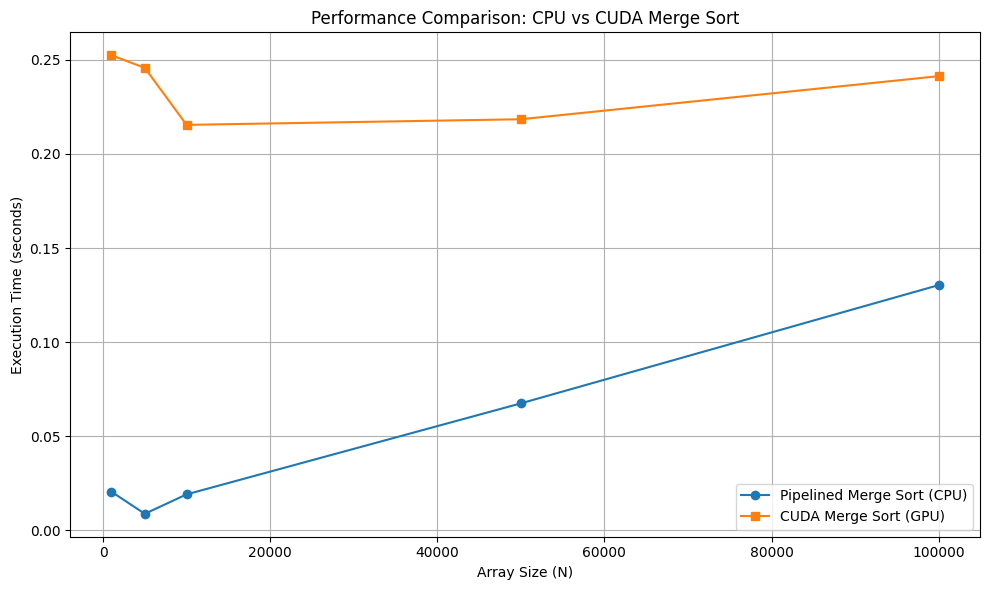

In [9]:
import subprocess
import matplotlib.pyplot as plt

sizes = [1000, 5000, 10000, 50000, 100000]
cpu_times = []
gpu_times = []

# Compile the CUDA code
!nvcc -Xcompiler -fopenmp mergesort_compare.cu -o mergesort_compare

for size in sizes:
    result = subprocess.run(
        ['./mergesort_compare', str(size)],
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True
    )
    output = result.stdout

    # Extract timing data
    cpu_line = [line for line in output.splitlines() if "Pipelined Merge Sort Time" in line]
    gpu_line = [line for line in output.splitlines() if "CUDA Merge Sort Time" in line]

    cpu_time = float(cpu_line[0].split()[-2])
    gpu_time = float(gpu_line[0].split()[-2])

    cpu_times.append(cpu_time)
    gpu_times.append(gpu_time)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(sizes, cpu_times, label='Pipelined Merge Sort (CPU)', marker='o')
plt.plot(sizes, gpu_times, label='CUDA Merge Sort (GPU)', marker='s')
plt.xlabel('Array Size (N)')
plt.ylabel('Execution Time (seconds)')
plt.title('Performance Comparison: CPU vs CUDA Merge Sort')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
